In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import getdata as gd

In [2]:
import strategy.trendlabeling as tlb

In [3]:
import getdata as gd
import afml.filters.filters as flt 
import afml.labeling.triplebarrier as tbar
import afml.util.volatility as vol
import features.bars as bars  
import features.marketindicators as mkt

In [4]:
import matplotlib.pyplot as plt

## Import Dataset

In [29]:
df_yf = gd.get_yf_data(tickers= "SPY COMP AAPL ALGM DNOW META", 
                    period='1y',   
                    interval='1d')

[*********************100%***********************]  6 of 6 completed


In [30]:
df = df_yf[df_yf['Ticker'] == 'ALGM']
index_SPY = df_yf[df_yf['Ticker'] == 'SPY']
index_COMP = df_yf[df_yf['Ticker'] == 'COMP']

## Get Labels using Trend Scanning method

In [7]:
# convert Adj Close to numpy
time_series = df['Adj Close'].to_numpy()
window_size_max= 7

# get trend scanning labels
label_output = tlb.get_trend_scanning_labels(time_series=time_series, 
                                             window_size_max=window_size_max, 
                                             threshold=0.0,
                                             opp_sign_ct=3,
                                             side='up')

# drop last rolling window size -1 rows
n = window_size_max-1
#df.drop(df.tail(n).index, inplace = True)
df = df.iloc[:-n]

# append the slope and labels to the df
df['slope'] = label_output['slope']
df['label'] = label_output['label']
# df['isEvent'] = label_output['isEvent']
# isEvent = df[df['isEvent']==1].index

## Form Dollar Bars

In [8]:
# construct the input data
_df = df.reset_index()
trades = _df[['Date', 'Adj Close', 'Volume']].to_numpy()

# define the dollar value to sample the data
frequency = _df.Volume.mean()*20

# generate the dollar bars
dollar_bars = bars.generate_dollarbars(trades, frequency=frequency) 

# define closing price
close = dollar_bars.close.copy()

In [9]:
# get Daily Volatility
dailyVolatility = vol.getDailyVol(close, span=50)

In [10]:
# apply cusum filter to identify events as cumulative log return passed threshold
tEvents = flt.getTEvents(close, h=dailyVolatility.mean())

## Create Trade or Not Trade labels using Triple Barrier Method

In [11]:
# Define vertical barrier - subjective judgment
num_days = 10

t1 = tbar.add_vertical_barrier(tEvents, close, num_days=num_days)

In [12]:
# get side labels from trend following method
side_labels = []

for dt in dollar_bars.index:
    side_labels.append(df.loc[dt]['label'])

side_labels = pd.Series(side_labels, index=dollar_bars.index)

In [13]:
# Define upper and lower horizontal barriers
# set profit and stop loss ratio
ptsl = [2,1]

# select minRet
minRet = 0.01 # requires at least 1 percent return

# Run in single-threaded mode on Windows
import platform, os
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = os.cpu_count() - 1
    
events = tbar.get_events(dollar_bars.close, 
                         t_events=tEvents[1:], 
                         pt_sl=ptsl, 
                         target=dailyVolatility, 
                         min_ret=minRet, 
                         num_threads=cpus, 
                         vertical_barrier_times=t1,
                         side_prediction=side_labels).dropna()

labels = tbar.get_bins(triple_barrier_events = events, close=close)

print(labels.bin.value_counts())

c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\labeling\triplebarrier.py:50: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, vertical_barrier in events_['t1'].fillna(close.index[-1]).iteritems():
c:\Users\choit\OneDrive\Coursera\SIADS699\capstone_git\MADS_Capstone\afml\util\multiprocess.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


0    89
1    53
Name: bin, dtype: int64


In [14]:
# Drop underpopulated labels
clean_labels  = tbar.drop_labels(labels)

print(clean_labels.bin.value_counts())

0    89
1    53
Name: bin, dtype: int64


In [15]:
clean_labels

,ret,trgt,bin,side
2022-03-23,0.061462,0.018217,1,1.0
2022-03-25,-0.035641,0.036385,0,1.0
2022-03-29,0.132253,0.035012,1,-1.0
2022-03-31,0.117670,0.039976,1,-1.0
2022-04-04,0.107438,0.035391,1,-1.0
...,...,...,...,...
2023-02-17,0.036571,0.043208,0,-1.0
2023-02-21,0.058769,0.043756,0,1.0
2023-02-22,0.053671,0.044008,0,1.0
2023-02-23,-0.034399,0.043149,0,-1.0


#### Use features: volatility, serial correlation, relative strength to S&P

In [38]:
# serial correlation
srl_corr = mkt.df_rolling_autocorr(mkt.returns(close), window=7).rename('srl_corr')

# relative strength to SPY
rs_SPY = mkt.get_relative_strength(df['Adj Close'], index_SPY['Adj Close']).dropna()


In [39]:
features = (pd.DataFrame()
            .assign(vol=events.trgt)
            .assign(side=clean_labels.side)
            .assign(srl_corr=srl_corr)
            .assign(rs_SPY=rs_SPY)
            .drop_duplicates()
            .dropna())

In [40]:
Xy = (pd.merge_asof(features, clean_labels.bin, 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())

In [41]:
Xy.bin.value_counts()

0    88
1    49
Name: bin, dtype: int64

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [42]:
RANDOM_STATE = 42

X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

              precision    recall  f1-score   support

           0       0.71      0.88      0.79        48
           1       0.40      0.19      0.26        21

    accuracy                           0.67        69
   macro avg       0.56      0.53      0.52        69
weighted avg       0.62      0.67      0.62        69



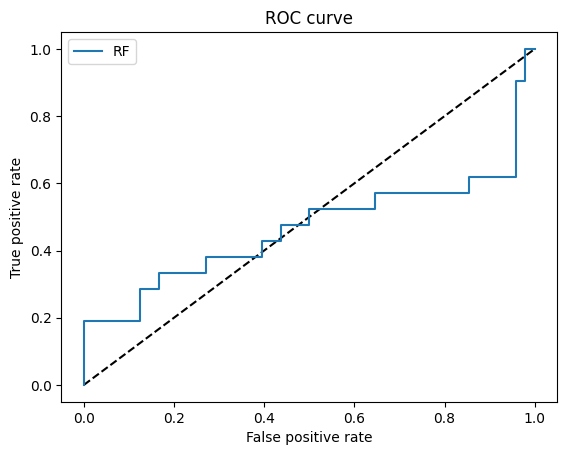

In [43]:
n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', 
                            #class_weight='balanced_subsample',
                            random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()